<font size=6><b> Stock Prediction (LSTM)

In [1]:
# ! pip install pandas_datareader
# ! pip install yfinance
# ! pip install plotly

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
# import os
# print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
#------------------------------------ 금융차트 --------------------
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

#------------------------------------ 금융 --------------------
from pandas_datareader.data import DataReader
import yfinance as yf

#------------------------------------ 전처리 --------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#------------------------------------ MODEL --------------------
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization ,  Flatten, LSTM, GRU
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#------------------------------------ STAT. --------------------
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

sns.set()

# Data Load

In [3]:
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)
stock_data = DataReader('TSLA', 'yahoo', start, end)
stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-09-05,23.699333,23.059334,23.586666,23.306000,57526500.0,23.306000
2017-09-06,23.398666,22.770666,23.299999,22.968666,61371000.0,22.968666
2017-09-07,23.498667,22.896667,23.065332,23.374001,63588000.0,23.374001
2017-09-08,23.318666,22.820000,23.266001,22.893333,48952500.0,22.893333
2017-09-11,24.247334,23.333332,23.423332,24.246000,115006500.0,24.246000


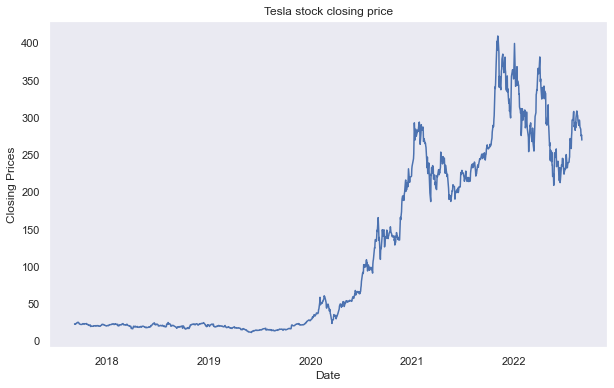

In [4]:
df_close = stock_data['Close']
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Tesla stock closing price')
plt.show()

# 정상성(stationary) 체크
* rolling statistics plots 
* Dickey-Fuller test (대립 가설: 모델은 정상성을 띤다)

In [5]:
def my_check_stationarity(timeseries_df):
    # rolling : mean, std ------------------------------------------
    rolmean = timeseries_df.rolling(20).mean()
    rolstd = timeseries_df.rolling(20).std()
    orig = plt.plot(timeseries_df, color='blue',label='original')
    mean = plt.plot(rolmean, color='red', label='rolling mean')
    std  = plt.plot(rolstd, color='black', label = 'rolling std')
    plt.legend()
    plt.title('rolling mean , std')
    plt.show(block=False)

    
    # Dickey-Fuller test ------------------------------------------
    print('Dickey-Fuller test:')
    dkf_test = adfuller(timeseries_df, autolag='AIC')
    dkf_test_res = pd.Series(dkf_test[0:4], index=['Test Statistic','p-value', '#Lags Used','Number of Observations Used'])
    for key,value in dkf_test[4].items():
        dkf_test_res['Critical Value (%s)'%key] = value
    print(dkf_test_res)

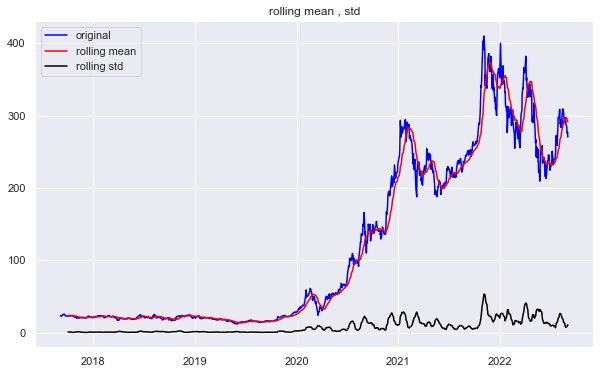

Dickey-Fuller test:
Test Statistic                   -0.818130
p-value                           0.813738
#Lags Used                       18.000000
Number of Observations Used    1240.000000
Critical Value (1%)              -3.435635
Critical Value (5%)              -2.863874
Critical Value (10%)             -2.568012
dtype: float64


In [6]:
plt.figure(figsize = (10,6))
my_check_stationarity(df_close.head(2000))

<pre><font color=red><b>
* rolling mean 증가 : 비정상성
* p-value(0.813738) > 0.05     : 귀무가설(모델은 정상성을 띠지 않는다) 채택

# 시계열데이터 분해(decompose) 
<font color=red><b>정상성 데이터 만들기</b></font>
* trend, seasonality , cycles, residual, etc
* 분산이 큰경우 : log변환, 제곱근변환
* 평균이 일정하지 않은 경우 : 차분


<Figure size 432x288 with 0 Axes>

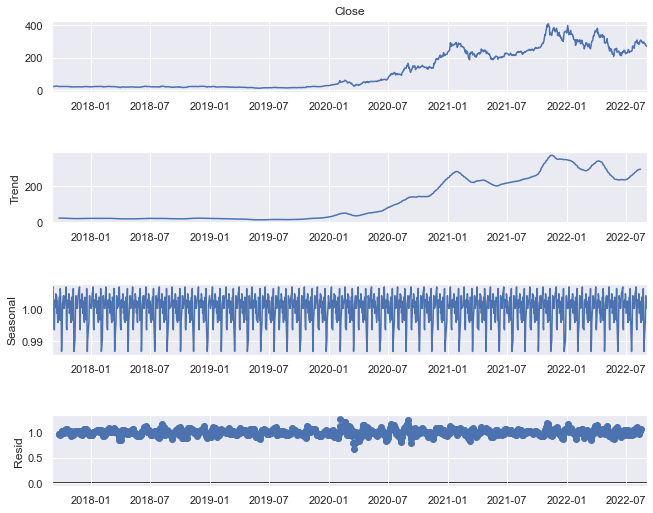

In [7]:
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)
plt.show()

## 분산 : 로그변환, 제곱근변환

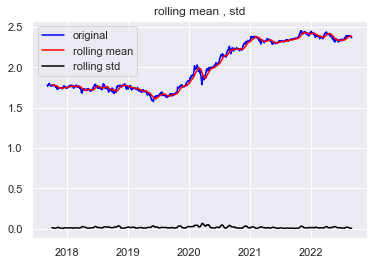

Dickey-Fuller test:
Test Statistic                   -0.285590
p-value                           0.927521
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


In [8]:
df_close_log = df_close.apply(np.log)
df_close_df = df_close_log.apply(np.sqrt)
my_check_stationarity(df_close_df)

<pre><font color=red><b>
* rolling mean 증가 : 비정상성
* p-value(0.927521) > 0.05     : 귀무가설(모델은 정상성을 띠지 않는다) 채택

## 평균 : 차분

In [9]:
df_close_shift = df_close_df - df_close_df.shift()
df_close_shift.head()

Date
2017-09-05         NaN
2017-09-06   -0.004113
2017-09-07    0.004934
2017-09-08   -0.005862
2017-09-11    0.016148
Name: Close, dtype: float64

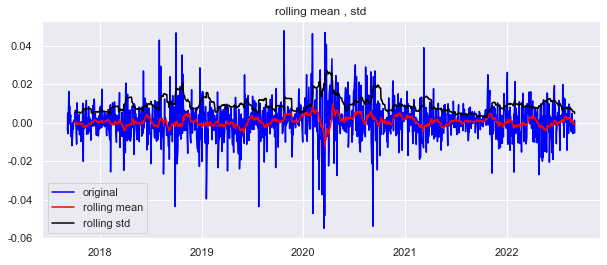

Dickey-Fuller test:
Test Statistic                  -36.275988
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1257.000000
Critical Value (1%)              -3.435563
Critical Value (5%)              -2.863842
Critical Value (10%)             -2.567996
dtype: float64


In [10]:
df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,4))
my_check_stationarity(df_close_shift)

<pre><font color=red><b>
* rolling mean 증가 : 정상성
* p-value(0.000000) < 0.05     : 귀무가설(모델은 정상성을 띠지 않는다) 기각 , 대립가설(모델은 정상성을 띤다) 채택

# LSTM 모델
* Recurrent Neural Network (RNN) 모델<br><br>
<font color=red><b><pre>
Input : [1,2,3,4,5,6,7,8,9,10]
X     : [1,2,3,4], [2,3,4,5], [3,4,5,6], ...
y     : [5,6,7,...]
X_train.shape  : [samples, timesteps, features]  --> [row수, rolling window크기, feature수]
rolling window : 60일

## 데이터 shape 가공
<font color=red><b>X_train.shape : [samples, timesteps, features] 

In [11]:
# def my_make_data(sequence, n_steps,n_features):
#     X, y = list(), list()
#     for i in range(len(sequence)):
#         # find the end of this pattern
#         end_ix = i + n_steps
#         # check if we are beyond the sequence
#         if end_ix >= len(sequence):
#             break
#         # gather input and output parts of the pattern
#         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
#         X.append(seq_x)
#         y.append(seq_y)
        
#     X = np.array(X)
#     y = np.array(y)

#     X = X.reshape((X.shape[0], X.shape[1], n_features))
#     return X, y

def my_make_data(data_arr, window_size, features):
    X = []
    y = []
    for i in range(len(data_arr)):
        end_idx = i + window_size
        if end_idx >= len(data_arr):
            break
        seq_x, seq_y = data_arr[i:end_idx]+N_FEATUERES, data_arr[end_idx]+N_FEATUERES
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], features))
    return X, y

In [12]:
df_close_shift[:5]

Date
2017-09-06   -0.004113
2017-09-07    0.004934
2017-09-08   -0.005862
2017-09-11    0.016148
2017-09-12   -0.000725
Name: Close, dtype: float64

In [13]:
print(df_close_shift.shape)

n_days = 60
n_features = 5
X, y = my_make_data(df_close_shift.to_numpy(), n_days, n_features)
print(X.shape, y.shape)   

# [row수, rolling window크기, feature수]

(1258,)


ValueError: cannot reshape array of size 71880 into shape (1198,60,5)

In [ ]:
DFDFDF

## train, test 분리

In [ ]:
test_days = 365 
X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test   = X[-test_days:], y[-test_days:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]
plt.figure(figsize=(10,6))
plt.ylabel('closing prices')
plt.plot(train_original, 'b', label='train')
plt.plot(test_original, 'r',  label='test')
plt.legend()
plt.show()

## 모델 생성

In [ ]:
model = Sequential()    
model.add(LSTM(units=50, input_shape=(n_days, n_features)))
model.add(Dense(1))
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          batch_size = 32)

In [ ]:
mse, mae = model.evaluate(X_test, y_test, batch_size=32)
print(f"MSE: {mse}  MAE:{mae}")

## 예측

In [ ]:
pred = model.predict(X_test)


# Plot actual prices vs predicted prices 

pred_df = pd.DataFrame(pred[:,0],  test_original.index,  columns=['pred'])
pred_df['pred2'] = pred_df['pred'] + df_close_df.shift().values[-test_days:] 
pred_df = pred_df.apply(np.square)
pred_df = pred_df.apply(np.exp)

plt.figure(figsize=(10,4))
plt.ylabel('close price')
plt.plot(test_original     , 'r'     ,label='y_test')
plt.plot(pred_df['pred2']  , 'green' ,label='pred')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
plt.ylabel('close price')
plt.plot(train_original   , 'b', label='train')
plt.plot(test_original    , 'r', label='test')
plt.plot(pred_df['pred2'] , 'g', label='pred')
plt.legend()
plt.show()

# Multi-Step LSTM 
* Recurrent Neural Network (RNN) 모델<br><br>
<font color=red><b><pre>
Input : [1,2,3,4,5,6,7,8,9,10]
X     : [1,2,3,4], [2,3,4,5], [3,4,5,6], ...
<font color=red><b>y     : [5,6,7,...]  --> [5,6,7],[6,7,8],[7,8,9]</b></font>
X_train.shape  : [samples, timesteps, features]  --> [row수, rolling window크기, feature수]
rolling window : 60일

In [ ]:
def my_make_data_multistep(data_arr, n_steps_in, n_steps_out, features):
    X = []
    y = []
    for i in range(len(data_arr)):
        # end_idx = i + window_size --------------------------------------------- single feature
        end_idx = i + n_steps_in
        out_end_ix = end_idx + n_steps_out
        if out_end_ix > len(data_arr):
            break
        # seq_x, seq_y = data_arr[i:end_idx], data_arr[end_idx]   --------------- single feature
        seq_x, seq_y = data_arr[i:end_idx], data_arr[end_idx:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], features))
    return X, y

In [ ]:
print(df_close_shift.shape)

n_steps_out = 10
n_days = 60
n_features = 1
# X, y = my_make_data(df_close_shift.to_numpy(), n_days, n_features)
X, y = my_make_data_multistep(df_close_shift.to_numpy(), n_days, n_steps_out, n_features)
print(X.shape, y.shape)   

# [row수, rolling window크기, feature수]
# (1258,)
# (1198, 60, 1) (1198,) --------------------------------------------- (single feature - n_steps_out)

## train, test 분리

In [ ]:
test_days = 365 
X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test   = X[-test_days:], y[-test_days:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# (833, 60, 1) (833,) (365, 60, 1) (365,)  --------------------------------------------- (single feature - n_steps_out) 

In [ ]:
train_original = df_close.iloc[:-test_days]
test_original  = df_close.iloc[-test_days:]
plt.figure(figsize=(10,6))
plt.ylabel('closing prices')
plt.plot(train_original, 'b', label='train')
plt.plot(test_original, 'r',  label='test')
plt.legend()
plt.show()

## 모델 생성

In [ ]:
model = Sequential()    
model.add(LSTM(units=50, input_shape=(n_days, n_features)))
# model.add(Dense(1))       --------------------------------------------- (single feature)
model.add(Dense(n_steps_out))
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          batch_size = 32)

In [ ]:
mse, mae = model.evaluate(X_test, y_test, batch_size=32)
print(f"MSE: {mse}  MAE:{mae}")

# MSE: 5.954952212050557e-05  MAE:0.005700898356735706   ------------- (single feature)

## 예측

In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape, y_pred)

the_day = 0
y_pred_days = y_pred[0,:]
print(y_pred_days.shape,  y_pred_days)

pred_cumsum = y_pred_days.cumsum()
print(pred_cumsum.shape,  pred_cumsum)

In [ ]:
# n_steps_out = 10
# n_days = 60
base_val = df_close_df.values[-test_days+n_days-1]
base_idx  = df_close_df.index[-test_days+n_days-1]

print(f"test시작일자: {df_close_df.index[-test_days]}")
print(f"window_size 롤링 후 test시작일자,값: {base_idx}  {base_val}")

idx = test_original.iloc[0:n_steps_out].index
print(idx)

pred_df2 = pd.Series(base_val, index=idx)
pred_df2 = pred_df2.add(pred_cumsum,fill_value=0)
print(pred_df2)

In [ ]:
pred_df2 = pred_df2.apply(np.square)
pred_df2 = pred_df2.apply(np.exp)
print(pred_df2.shape, pred_df2)

In [ ]:
plt.figure(figsize=(10,4))
plt.ylabel('close price')
plt.plot(test_original.iloc[0:n_steps_out] ,'-o' 'r'          ,label='original')
plt.plot(pred_df2,                          '-o', color='green',label='pred')
plt.legend()
plt.show()